In [66]:
#https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

In [181]:
#Configuring the IO structure:
W_size=3
st=4
et=22
Bin_size=1
prediction_size=1
n_features=282
irows=int(W_size/Bin_size)
icols=n_features
orows=int(prediction_size/Bin_size)
ocols=147

In [182]:
# Data Preparation
import pandas as pd
# Selecting data based on bin size
if Bin_size==0.5:
    df2 = pd.read_csv('/home/pennyworth/Documents/Bus/Data/from_R_19B_30min_normed.csv',header =None)
if Bin_size==1:
    df2 = pd.read_csv('/home/pennyworth/Documents/Bus/Data/from_R_19B_1Hr_normed.csv',header =None)
    
#Converting dataframe into matrix    
dataset=df2.as_matrix()

/home/pennyworth/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


In [183]:
#Checking if the import is good to go:
if len(dataset)-1==34*18/Bin_size:
    print("Import successful!")

Import successful!


In [184]:
print(irows,orows)

3 1


In [185]:
#Fixing number of clusters:
nclust=4

#Selecting correlated time bins based on cluster number
if nclust==4:
    df_clust = pd.read_csv('/home/pennyworth/Documents/Bus/Data/STcor_Tree_4branch.csv',header =None)
if nclust==3:
    df_clust = pd.read_csv('/home/pennyworth/Documents/Bus/Data/STcor_Tree_3branch.csv',header =None)
if nclust==2:
    df_clust = pd.read_csv('/home/pennyworth/Documents/Bus/Data/STcor_Tree_2branch.csv',header =None)
index_ps=df_clust[1]

#Creating a list of start time to consider for each model
st2consider=[]
for i in range(nclust):
    st2consider.append([])

#Appending values to cols2consider
for i in range(1,len(index_ps)):
    bloc=int(index_ps[i])
    st2consider[bloc-1].append(i)
    
# Note: Here, in elements of cols2consider, time bins start from 1 and go till 18.
# but while indexing in dataset, it should start from 0 therefore we subtract 1 
# from elements in cols2consider
c2c_copy=st2consider
st2consider=[]
for ar in c2c_copy:
    st2consider.append([k-1 for k in ar])

if st2consider[0]==[k-1 for k in c2c_copy[0]]:
    print("Unit Subraction from st2consider complete! \n")
else:
    print("ERROR: Something wrong with subraction! \n")

#Check if everything is fine
index_l=index_ps.tolist()      # converting pandas series to list
if index_l.count('1')==len(st2consider[0]) and (len(st2consider[nclust-1])==index_l.count(str(nclust))):
    print("Good to go! st2consider seems good..")

Unit Subraction from st2consider complete! 

Good to go! st2consider seems good..


In [191]:
print(st2consider)

[[0, 1, 16], [2, 17], [3, 5, 12, 13, 15], [4, 6, 7, 8, 9, 10, 11, 14]]


In [187]:
# Tutorial or recap:
# The last index is excluded therefore to select 1-18(inclusive) we have to do 1-19
a=[0,1,2,3,4,5,6,7,8,9,10]
print(a[1:4],a[4:7])

[1, 2, 3] [4, 5, 6]


In [188]:
#Tutorial lession for Python0
#df2[:][] # indicates 1st[actaully 2nd] col 2nd[actually 3rd] row
#df2.iloc[0]

In [189]:
# Data from R is same for any bin size.
tdmax=22.8
tdmin=4.066667
def normed2normal(time):
    timo=time*(tdmax - tdmin)+tdmin
    return timo
# Working beautifully for given Min and max time.
#normed2normal(day_df[281])

In [180]:
#Defining a list to put sequences in
sequences_by_grp=[]
for grp in range(nclust):
    sequences_by_grp.append([])

#Define the rows per day
rows_pd=int((et-st)/Bin_size)

#For each day travel times in df2
for day in range(1,int((len(df2)-1)/rows_pd+1)):
    strt_row=day*rows_pd-17
    end_row=strt_row+rows_pd
    #print("The rows are:",strt_row,end_row)
    day_df=(df2.iloc[strt_row:end_row])
    #For each group according to clustered start times
    for grp in range(nclust):
        #print(st2consider[grp])
        #Creating a list for adding numpy arrays of seg tt for st in the group
        tt_group=[]
        #For each element in the group
        for start_t in st2consider[grp]:
            #print("Start:",st+4,"End:",st+5)
            #Selecting the entry with denormalized st within the range
            selected_df=day_df.loc[(normed2normal(day_df[281]) >= start_t+4) & (normed2normal(day_df[281]) <= start_t+5)]
            #Taking mean in case multiple values are present
            pdseries=selected_df.mean()
            #Converting those into a numpy array and putting it in tt_group
            tt_group.append(pdseries.as_matrix())
            #Works good don't touch
        #Appending the matrix to the marticular group
        sequences_by_grp[grp].append(tt_group)
if len(sequences_by_grp)==nclust and len(sequences_by_grp[0])==34 and len(sequences_by_grp[0][0])==3:
    print("Creation of sequences good!")
else:
    print("ERROR: Creation of sequences lengths arent as expected")

/home/pennyworth/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Creation of sequences good!


In [27]:
# Function to check a X,y pair and look at the lengths:
# Not yet prepared for Model-4
# def verify_io(Xi,yi,info,i):
#     if info==True:
#         print("Number of X matrices:",len(Xi))
#         print("Number of y matrices:",len(yi))
#         print("Number i/o pairs expected:",(rows_pday-irows-orows+1)*34)
#     elif(len(Xi)==len(yi)==(rows_pday-irows-orows+1)*34):
#         print("Number of i/o pairs is as expected!")
#     else:
#         print("ERROR: Number of i/o pairs is not as expected!")
#     if info==True:
#         print("Number of features in each X matrix:",len(Xi[0][1]))
#         print("Number of features in each y matrix:",len(yi[0]))
#         print("Number of features expected:",len(cols2consider[i])+2,"for X")
#     elif(len(Xi[0][1])-2==len(yi[0])==len(cols2consider[i])):
#         print("Number of features is as expected!")
#     else:
#         print("ERROR: Number of features is not as expected!")


In [226]:
import numpy as np
#Split sequences according to group number given:
def split_sequences_by_grp(sequences, n_steps_in, n_steps_out,grp_no): # Grp no should start from 0
    for i in range(len(sequences)):
        # Find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # Check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # Gather input and output parts of the pattern
        print
        seq_x =sequences[i:end_ix,:]
        seq_y = sequences[end_ix:out_end_ix,:,:-2][0]
        Xl[grp_no].append(seq_x)
        yl[grp_no].append(seq_y)
    # Change th +2 below incase the number of inputs and outputs is changed
    #first[0] indicates 1st day of the 3 day input. next[0] indicates 1st start time in grp
    if len(seq_x[0][0])!= len(seq_y[0])+2:
        print("ERROR: column selection wrong!")
    return None

In [223]:
# multivariate multi-step data preparation
import numpy as np
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# Create a list of X and y to put in X and y for different groups.
yl=[]
for i in range(nclust):
    yl.append([])
Xl=[]
for i in range(nclust):
    Xl.append([])
    

n_steps_in, n_steps_out = 3, 1

#Generate IO Matrices
for grp in range(nclust):
    split_sequences_by_grp(np.asarray(sequences_by_grp[grp]), n_steps_in, n_steps_out,grp)

# for i in range(1,35):
#     todays_df=dataset[(i-1)*rows_pday+1:i*rows_pday+1]
#     for j in range(nclust):
#         split_sequences_by_grp(todays_df, n_steps_in, n_steps_out,j)

# #Check if the matrix are created properly:
# verify_io(Xl[0],yl[0],False,0)
# verify_io(Xl[1],yl[1],True,1)
# verify_io(Xl[2],yl[2],False,2)
# verify_io(Xl[3],yl[3],False,3)
#Pending verification

In [230]:
#Filtering the Na IO matrices out
from math import isnan
import numpy as np

# #Function to check if all the NA matrices are deleted.
def check_NA(X_fil,y_fil,Name):
    Na_count=0
    for i in range(len(X_fil)):
        if np.any(np.isnan(y_fil[i]))==True & np.any(np.isnan(X_fil[i]))==True:
            Na_count=Na_count+1
    if Na_count==0:
        print("Na Matrices filtered out sucessfuly in",Name,"!")
    else:
        print("ERROR: NA value found!")
        
#Function to filter the NA matrices.
def filter_NA(X_o,y_o):
    X_fil=np.array(X_o)
    y_fil=np.array(y_o)
    del_index=[]
    # Noting down the index of Na matrices in del_index 
    for i in range(len(X_fil)):
        del_index.append(np.any(np.isnan(X_fil[i])) or np.any(np.isnan(y_fil[i])))
    # Filtering out the Na matrices from y_fil and X_fil by indexing using a list
    y_fil=y_fil[list(~np.array(del_index))]
    X_fil=X_fil[list(~np.array(del_index))]
    return X_fil,y_fil


X1,y1=filter_NA(Xl[0],yl[0])
X2,y2=filter_NA(Xl[1],yl[1])
X3,y3=filter_NA(Xl[2],yl[2])
X4,y4=filter_NA(Xl[3],yl[3])

check_NA(X1,y1,"G1")
check_NA(X2,y2,"G2")
check_NA(X3,y3,"G3")
check_NA(X4,y4,"G4")

Na Matrices filtered out sucessfuly in G1 !
Na Matrices filtered out sucessfuly in G2 !
Na Matrices filtered out sucessfuly in G3 !
Na Matrices filtered out sucessfuly in G4 !


In [233]:
# Print number of IO Pairs available:
print(len(y2)," I/O pairs available")
#verify_io(X1,y1,True,0)

8  I/O pairs available


In [15]:
# Function to Flatten output
verify_io(Xl[0],yl[0],True,0)

# Note: No need to flatten output as y already has only 2 dimensions.
y1.shape
# def Flatten_output(y_il):
#     n_output = y_il.shape[1] * y_il.shape[2]
#     return y_il.reshape((y_il.shape[0], n_output))

# print(y1)
# y1=Flatten_output(y1)
# y2=Flatten_output(y2)
# y3=Flatten_output(y3)
# y4=Flatten_output(y4)

Number of X matrices: 510
Number of y matrices: 510
Number i/o pairs expected: 510
Number of features in each X matrix: 70
Number of features in each y matrix: 68
Number of features expected: 70 for X


(289, 68)

In [16]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [17]:
verify_io(X1,y1,True,0)
X1.shape

Number of X matrices: 289
Number of y matrices: 289
Number i/o pairs expected: 510
Number of features in each X matrix: 70
Number of features in each y matrix: 68
Number of features expected: 70 for X


(289, 3, 70)

In [18]:
# Splitting into train and test sets
np.random.seed(95)
msk = np.random.rand(len(X1)) < 0.8
X_train = X1[msk]
y_train = y1[msk]
X_test = X1[~msk]
y_test = y1[~msk]
print("Dataset splitting done! for Grp-1")

#Verify shape once:
#verify_io(X_test,y_test,False,0)


n_output=len(y_train[0])
n_colx=len(X1[0][0])

# multivariate output multi-step 1d cnn example

# define model
model1 = Sequential()
model1.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(irows, n_colx)))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Flatten())
model1.add(Dense(500, activation='relu'))
model1.add(Dense(n_output))
model1.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=12

# fit model
history=model1.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Group-1 ; Model-3 \n")
print("Number or epochs:",epochno)
print("Number of input features:",n_colx)
print("Number of output features:",n_output)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available for training:",len(y_train))
print("Number of I/O pairs available for testing:",len(y_test))
print("Model Mape loss:",model1.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model1.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model1.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

W0710 19:36:47.749396 140643315939136 deprecation_wrapper.py:119] From /home/pennyworth/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 19:36:47.752042 140643315939136 deprecation_wrapper.py:119] From /home/pennyworth/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0710 19:36:47.755317 140643315939136 deprecation_wrapper.py:119] From /home/pennyworth/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0710 19:36:47.790834 140643315939136 deprecation_wrapper.py:119] From /home/pennyworth/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W07

Dataset splitting done! for Grp-1


W0710 19:36:48.009555 140643315939136 deprecation_wrapper.py:119] From /home/pennyworth/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0710 19:36:48.171990 140643315939136 deprecation_wrapper.py:119] From /home/pennyworth/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Group-1 ; Model-3 

Number or epochs: 12
Number of input features: 70
Number of output features: 68
Bin size: 1
Window size: 3
Number of I/O pairs available for training: 230
Number of I/O pairs available for testing: 59
59/59 [==============================] - 0s 57us/step
Model Mape loss: 47.914530220678294
59/59 [==============================] - 0s 100us/step
Model MSE loss (Minimized): 0.0056986767419819105
59/59 [==============================] - 0s 140us/step
RMSE loss: 0.0754895803537277


In [19]:
# Splitting into train and test sets
np.random.seed(95)
msk = np.random.rand(len(X2)) < 0.8
X_train = X2[msk]
y_train = y2[msk]
X_test = X2[~msk]
y_test = y2[~msk]
print("Dataset splitting done! for Grp-2\n")

#Verify shape once:
verify_io(X_train,y_train,True,1)


n_output=len(y_train[0])
n_colx=len(X_train[0][0])

# multivariate output multi-step 1d cnn example

# define model
model2 = Sequential()
model2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(irows, n_colx)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(500, activation='relu'))
model2.add(Dense(n_output))
model2.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=12

# fit model
history=model2.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Group-2 ; Model-3 \n")
print("Number or epochs:",epochno)
print("Number of input features:",n_colx)
print("Number of output features:",n_output)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available for training:",len(y_train))
print("Number of I/O pairs available for testing:",len(y_test))
print("Model Mape loss:",model2.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model2.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model2.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

Dataset splitting done! for Grp-2

Number of X matrices: 230
Number of y matrices: 230
Number i/o pairs expected: 510
Number of features in each X matrix: 44
Number of features in each y matrix: 42
Number of features expected: 44 for X
Group-2 ; Model-3 

Number or epochs: 12
Number of input features: 44
Number of output features: 42
Bin size: 1
Window size: 3
Number of I/O pairs available for training: 230
Number of I/O pairs available for testing: 59
59/59 [==============================] - 0s 39us/step
Model Mape loss: 23.118215948848402
59/59 [==============================] - 0s 110us/step
Model MSE loss (Minimized): 0.0017311514919560592
59/59 [==============================] - 0s 226us/step
RMSE loss: 0.041607108670947794


In [20]:
# Splitting into train and test sets
np.random.seed(95)
msk = np.random.rand(len(X3)) < 0.8
X_train = X3[msk]
y_train = y3[msk]
X_test = X3[~msk]
y_test = y3[~msk]
print("Dataset splitting done! for Grp-3\n")

#Verify shape once:
verify_io(X_train,y_train,True,2)


n_output=len(y_train[0])
n_colx=len(X_train[0][0])

# multivariate output multi-step 1d cnn example

# define model
model3 = Sequential()
model3.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(irows, n_colx)))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Flatten())
model3.add(Dense(500, activation='relu'))
model3.add(Dense(n_output))
model3.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=12

# fit model
history=model3.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Group-3 ; Model-3 \n")
print("Number or epochs:",epochno)
print("Number of input features:",n_colx)
print("Number of output features:",n_output)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available for training:",len(y_train))
print("Number of I/O pairs available for testing:",len(y_test))
print("Model Mape loss:",model3.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model3.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model3.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

Dataset splitting done! for Grp-3

Number of X matrices: 230
Number of y matrices: 230
Number i/o pairs expected: 510
Number of features in each X matrix: 31
Number of features in each y matrix: 29
Number of features expected: 31 for X
Group-3 ; Model-3 

Number or epochs: 12
Number of input features: 31
Number of output features: 29
Bin size: 1
Window size: 3
Number of I/O pairs available for training: 230
Number of I/O pairs available for testing: 59
59/59 [==============================] - 0s 40us/step
Model Mape loss: 73.63426441257283
59/59 [==============================] - 0s 88us/step
Model MSE loss (Minimized): 0.005403270905490144
59/59 [==============================] - 0s 197us/step
RMSE loss: 0.0735069446072284


In [21]:
# Splitting into train and test sets
np.random.seed(95)
msk = np.random.rand(len(X4)) < 0.8
X_train = X4[msk]
y_train = y4[msk]
X_test = X4[~msk]
y_test = y4[~msk]
print("Dataset splitting done! for Grp-4\n")

#Verify shape once:
verify_io(X_train,y_train,True,3)


n_output=len(y_train[0])
n_colx=len(X_train[0][0])

# multivariate output multi-step 1d cnn example

# define model
model4 = Sequential()
model4.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(irows, n_colx)))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Flatten())
model4.add(Dense(500, activation='relu'))
model4.add(Dense(n_output))
model4.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=12

# fit model
history=model4.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Group-4 ; Model-3 \n")
print("Number or epochs:",epochno)
print("Number of input features:",n_colx)
print("Number of output features:",n_output)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available for training:",len(y_train))
print("Number of I/O pairs available for testing:",len(y_test))
print("Model Mape loss:",model4.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model4.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model4.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

Dataset splitting done! for Grp-4

Number of X matrices: 230
Number of y matrices: 230
Number i/o pairs expected: 510
Number of features in each X matrix: 143
Number of features in each y matrix: 141
Number of features expected: 143 for X
Group-4 ; Model-3 

Number or epochs: 12
Number of input features: 143
Number of output features: 141
Bin size: 1
Window size: 3
Number of I/O pairs available for training: 230
Number of I/O pairs available for testing: 59
59/59 [==============================] - 0s 52us/step
Model Mape loss: 2146.121499271716
59/59 [==============================] - 0s 149us/step
Model MSE loss (Minimized): 0.003139250335615065
59/59 [==============================] - 0s 69us/step
RMSE loss: 0.056029013337868666


dict_keys(['val_loss', 'val_mean_absolute_percentage_error', 'loss', 'mean_absolute_percentage_error'])


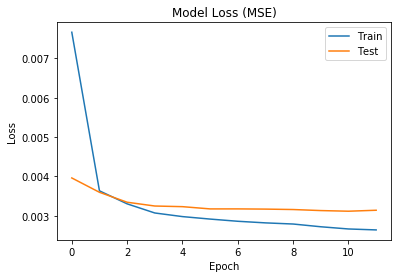

In [22]:
import matplotlib.pyplot as plt
import numpy
%matplotlib inline

print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#axes = plt.gca()
#axes.set_ylim([7500,0.2*100000])
#axes.set_xlim([1500,3000])
plt.show()

In [203]:
#history=model.fit(X, y, epochs=3000, verbose=1)
#model.evaluate(X,y)

In [27]:
# Plot a random Prediction vs actual travel time
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(88)
rnd=np.random.randint(len(X_test))

# Define a function that returns the segment if a touple with (index in list,tt)
def tellme_seg(tu):
    return orderlist[tu[0]]

#Reshaping input to be suitable for the observation
x1_input = X1[~msk][rnd].reshape((1, 3, len(X1[0][0])))
x2_input = X2[~msk][rnd].reshape((1, 3, len(X2[0][0])))
x3_input = X3[~msk][rnd].reshape((1, 3, len(X3[0][0])))
x4_input = X4[~msk][rnd].reshape((1, 3, len(X4[0][0])))

#Predicting values for each group for rnd observation
g1_yp=model1.predict(x1_input, verbose=0)
g2_yp=model2.predict(x2_input, verbose=0)
g3_yp=model3.predict(x3_input, verbose=0)
g4_yp=model4.predict(x4_input, verbose=0)

#Getting the real value for each group for the rnd
g1_ya=y1[rnd]
g2_ya=y2[rnd]
g3_ya=y3[rnd]
g4_ya=y4[rnd]

orderlist=[]
tt_list_ya=list(g1_ya)+list(g2_ya)+list(g3_ya)+list(g4_ya)
tt_list_yp=list(g1_yp[0])+list(g2_yp[0])+list(g3_yp[0])+list(g4_yp[0])
for grp in cols2consider:
    orderlist=orderlist+grp

# Defining a function to map travel times to the
def arrange_tt_by_seg(tlist):
    touple_list=[(i,tlist[i]) for i in range(len(tlist))]
    touple_list.sort(key=tellme_seg)
    sorted_tp_list=touple_list
    arranged_tt=[el[1] for el in sorted_tp_list]
    return arranged_tt

act=arrange_tt_by_seg(tt_list_ya)
pdt=arrange_tt_by_seg(tt_list_yp)
#print(type(g1_ya.shape),"\n\n")
#print(len(yhat[0]))
# pdt=yhat[0]
# act=y_output
# if len(pdt)==len(act):
#     print("Lengths match good to go!")

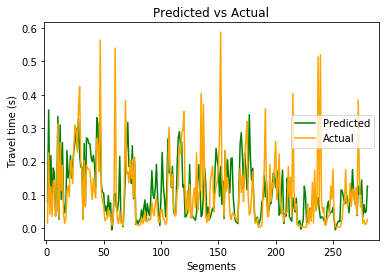

In [28]:
import matplotlib.pyplot as plt
import numpy

x=list(range(1,len(pdt)+1))
plt.plot(x, pdt[0:], color='g',label="Predicted")
plt.plot(x, act[0:], color='orange',label="Actual")
plt.xlabel('Segments')
plt.ylabel('Travel time (s)')
plt.title('Predicted vs Actual')
axes = plt.gca()
#axes.set_ylim([0,180])
axes.set_xlim([-2,len(pdt)+10])
leg = plt.legend();
#plt.show()